In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Load YOLOv4 model
def load_yolo_model(weights_path, config_path):
    net = cv2.dnn.readNet(weights_path, config_path)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    return net, output_layers

In [ ]:
# Process the image and perform object detection with YOLOv4
def detect_objects(image_path, net, output_layers):
    img = cv2.imread(image_path)
    height, width, channels = img.shape
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    return boxes, confidences, class_ids, img, height, width

In [ ]:
# Create the ROLO model
def create_rolo_model(input_shape, lstm_units):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(Dense(4, activation="sigmoid"))
    return model

# Apply the ROLO model to the YOLO output
def apply_rolo_model(yolo_outs, rolo_model):
    yolo_outs = np.expand_dims(yolo_outs, axis=0)
    rolo_outs = rolo_model.predict(yolo_outs)
    return rolo_outs

1/1 [==============================] - 0s 436ms/step


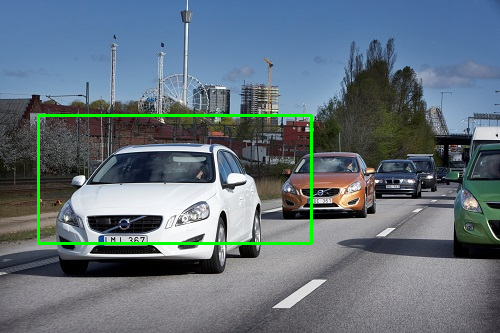

In [20]:

# Main function
def main():
    weights_path = "yolov4.weights"
    config_path = "yolov4.cfg"
    image_path = "image.jpg"

    # Load the YOLO model
    net, output_layers = load_yolo_model(weights_path, config_path)

    # Perform object detection with YOLOv4
    boxes, confidences, class_ids, img, height, width = detect_objects(image_path, net, output_layers)

    # Create the ROLO model
    rolo_model = create_rolo_model(input_shape=(None, 4), lstm_units=100)

    # Apply the ROLO model to the YOLO output
    boxes = np.array(boxes, dtype=np.float32)
    rolo_outs = apply_rolo_model(boxes, rolo_model)

    # Process the ROLO output and draw bounding boxes on the image
    for i in range(len(rolo_outs)):
        x, y, w, h = rolo_outs[i] * np.array([width, height, width, height])
        x, y, w, h = int(x - w / 2), int(y - h / 2), int(w), int(h)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the image with detected objects
    from google.colab.patches import cv2_imshow
    cv2_imshow(img)


if __name__ == "__main__":
    main()

